# 画像メディア工学７回目
## 7. 画像の復元と生成（ぼけ・ぶれ画像の復元）
### ライブラリの読み込み（おまじない）

In [ ]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

### Google colaboratoryで利用する場合の画像のアップロード
img02.pngをアップしてください

In [ ]:
!wget https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img02.png -O img02.png

--2025-11-22 02:18:23--  https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img02.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2346 (2.3K) [image/png]
Saving to: ‘img02.png’

img02.png           100%[===================>]   2.29K  --.-KB/s    in 0s      

2025-11-22 02:18:23 (30.9 MB/s) - ‘img02.png’ saved [2346/2346]



### 点拡がり関数の定義
以下の課題でも利用します

In [ ]:
# 円の点拡がり関数
def calcPSF1( height, width, R):
    h=np.zeros((height, width), dtype=np.float32)
    cv2.circle(h, (int(h.shape[0]/2), int(h.shape[1]/2)), R, 255, -1, 8)
    sum_h = sum(h.flatten())
    return h/sum_h

# 直線の点拡がり関数
def calcPSF2(height, width, L, theta):
    h=np.zeros((height, width), dtype=np.float32)
    spx,spy = int(L/2*np.cos(theta/180*np.pi)+h.shape[0]/2), int(L/2*np.sin(theta/180*np.pi)+h.shape[1]/2)
    epx,epy = int(L/2*np.cos((theta+180)/180*np.pi)+h.shape[0]/2), int(L/2*np.sin((theta+180)/180*np.pi)+h.shape[1]/2)
    cv2.line(h, (spx, spy), (epx, epy), 255, 1)
    sum_h = sum(h.flatten())
    return h/sum_h

### ウィーナーフィルタの定義

In [ ]:
# ウィーナーフィルタ
def calcWnrFilter(h, g, gamma):
    fft_h = np.fft.fft2(h, s = g.shape)
    return fft_h/(np.abs(fft_h)**2 + gamma)

### 劣化画像（ぼけ画像）の生成
ここでは，劣化していない画像から，点拡がり関数を用いて劣化画像を生成することで，点拡がり関数の正解がわかる状況としている．

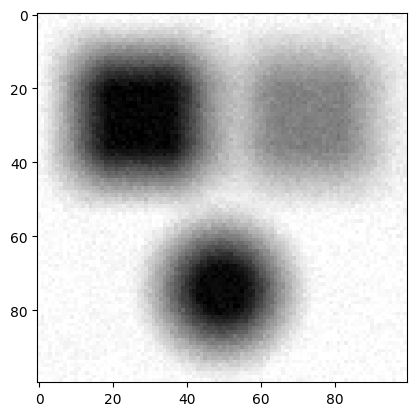

In [ ]:
R = 10                            # 点拡がり関数の大きさ（半径）
img = cv2.imread('img02.png', 0)  # モノクロ画像として読み込み
h = calcPSF1(img.shape[0],img.shape[1], R)  # 円の点拡がり関数の作成
g = cv2.filter2D(img, -1, h) + np.random.normal(0,5, img.shape)    # 劣化画像の生成

plt.imshow(g, cmap='gray', vmin = 0, vmax = 255);

### ウィーナーフィルタを用いたぼけ画像の復元
　$f, F$: 原画像（復元画像）とそのフーリエ変換

　$g, G$: 劣化画像とそのフーリエ変換

　$h$: 点拡がり関数

　$K_w$: ウィーナーフィルタ

原画像のフーリエ変換 $F$が，$F = K_w G$で計算できる．

$R$(ぼけの大きさ）や$gamma$（画像とノイズの比率）を変化させると，復元結果が変化しますので，実際に値を変更し確認してみてください．

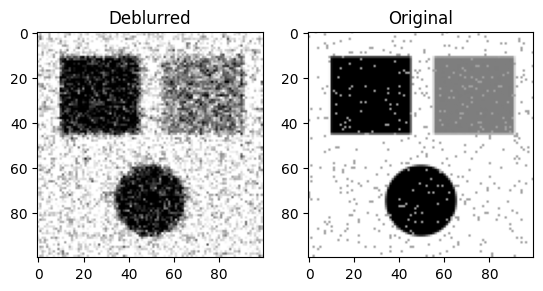

In [ ]:
# 復元時点拡がり関数の作成
# この例では，点拡がり関数の正解がわかっているが，実際には不明のため，点拡がり関数を推定する必要があることに注意
R = 10
h = calcPSF1(g.shape[0], g.shape[1], R)

# ウィーナーフィルタの計算
gamma = 1/1000
Kw = calcWnrFilter(h, g, gamma);

# ウィーナーフィルタの適用
G = np.fft.fft2(g)
F = Kw*G

# フーリエ逆変換
f = np.fft.ifft2(F)
f = np.fft.fftshift(f)

# 復元結果の表示
plt.subplot(121)
plt.title('Deblurred')
plt.imshow(f.real, cmap='gray', vmin = 0, vmax = 255);
plt.subplot(122)
plt.title('Original')
plt.imshow(img, cmap='gray', vmin = 0, vmax = 255);

### 課題
１．以下の劣化画像1,2を復元したいとき，PSF1～3のうち，どの点拡がり関数を利用すべきかを回答してください．

画像1：https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img05a.png

画像2：https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img05b.png

|画像1(img05a.png) |画像2(img05b.png) |
|:-|:-|
|<img src="https://github.com/yamazoe/ImageMediaProcessing/blob/main/img/img05a.png?raw=true" width=60%>|<img src="https://github.com/yamazoe/ImageMediaProcessing/blob/main/img/img05b.png?raw=true" width=60%>|

<img src="https://github.com/yamazoe/ImageMediaProcessing/blob/main/img/img05d.png?raw=true" width=60%>

以下のプログラムを実行しなくても回答はできるはずですが，
- 画像の読み込み部分
- ウィーナーフィルタの適用における$gamma$の値，$F$の計算式
を適切に修正すると，劣化画像の復元が実行できますので，確認してみてください．

２．以下の劣化画像を復元したい場合には，どのような点広がり関数を利用したらよいでしょうか？　文章で回答してください．

（例：画像１の場合であれば，斜め左上から右下方向に広がる点広がり関数，という回答）

<img src="https://github.com/yamazoe/ImageMediaProcessing/blob/main/img/img05c.png?raw=true" width=20%>

実行の前に，課題用のファイル（img05a.png,img05b.png）をアップしてください．

In [ ]:
!wget https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img05a.png -O img05a.png
!wget https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img05b.png -O img05b.png

--2025-11-22 02:18:25--  https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img05a.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4875 (4.8K) [image/png]
Saving to: ‘img05a.png’

img05a.png          100%[===================>]   4.76K  --.-KB/s    in 0s      

2025-11-22 02:18:25 (40.2 MB/s) - ‘img05a.png’ saved [4875/4875]

--2025-11-22 02:18:25--  https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img05b.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3892 (3.8K) [image/png]
Savi

処理を行う画像の読み込み
（いずれかをコメントアウトしてください）

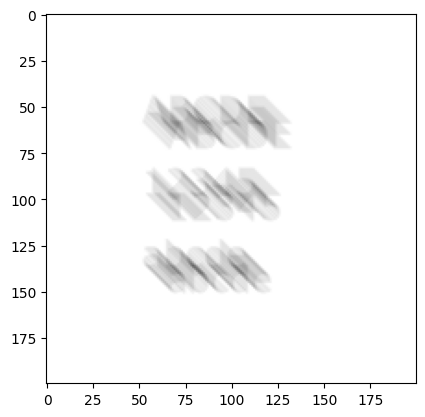

In [ ]:
g = cv2.imread('img05a.png', 0)
#g = cv2.imread('img05b.png', 0)
plt.imshow(g, cmap='gray', vmin = 0, vmax = 255);

3種類の点拡がり関数の定義

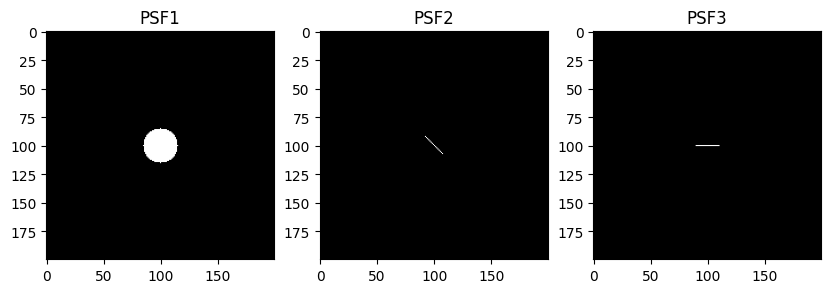

In [ ]:
R = 15
L = 20
theta = 45
theta2 = 0
h0 = calcPSF1(g.shape[0], g.shape[1], 1)
h1 = calcPSF1(g.shape[0], g.shape[1], R)
h2 = calcPSF2(g.shape[0], g.shape[1], L, theta)
h3 = calcPSF2(g.shape[0], g.shape[1], L, theta2)

plt.figure(figsize=(10, 30))
plt.subplot(131)
plt.title('PSF1')
plt.imshow(h1, cmap='gray');
plt.subplot(132)
plt.title('PSF2')
plt.imshow(h2, cmap='gray');
plt.subplot(133)
plt.title('PSF3')
plt.imshow(h3, cmap='gray');

ウィーナーフィルタの適用
- 画像に合わせて，gammaの値を設定してください
- 利用したいPSFによって，$F=H1*G$, $F=H2*G$, $F=H3*G$ のいずれかを選択してください

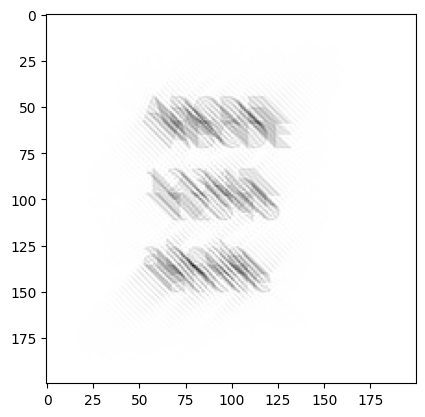

In [ ]:
# img05aの場合，gammma=1/5000.
# img05bの場合，gammma=1/500.としてください
gamma = 1/5000.
gamma = 1/500.

H0 = calcWnrFilter(h0, g, gamma)
H1 = calcWnrFilter(h1, g, gamma)
H2 = calcWnrFilter(h2, g, gamma)
G = np.fft.fft2(g)
F = H0*G            # 正しくないPSFの場合
#F = H1*G           # PSF1を利用する場合
#F = H2*G           # PSF2を利用する場合
#F = H3*G           # PSF3を利用する場合
f = np.fft.ifft2(F)
f = np.fft.fftshift(f)

plt.imshow(f.real, cmap='gray', vmin = 0, vmax = 255);